# 인덱스의 내부 작동

* 클러스터형 인덱스와 보조 인덱스는 모두 내부적으로 균형 트리로 만들어진다.
* **균형트리** -> '자료구조'에 나오는 범용적으로 사용되는 데이터 구조
* 나무를 거꾸로 표현한 자료 구조, 트리에서 제일 상단의 뿌리를 루트, 줄기를 중간, 끝에 달린 잎을 리프라고 부른다.

## 인덱스의 내부 작동 원리

### 균형 트리의 개념

* **노드**: 균형 노드에서 데이터가 저장되는 공간
* **루트 노드**: 노드의 가장 상위 노드, 모든 출발은 루트 노드에서 시작된다.
* **리프 노드**: 제일 마지막에 존재하는 노드
* 루트 노드와 리프 노드 중간에 끼인 노드들은 중간 노드라 부른다.

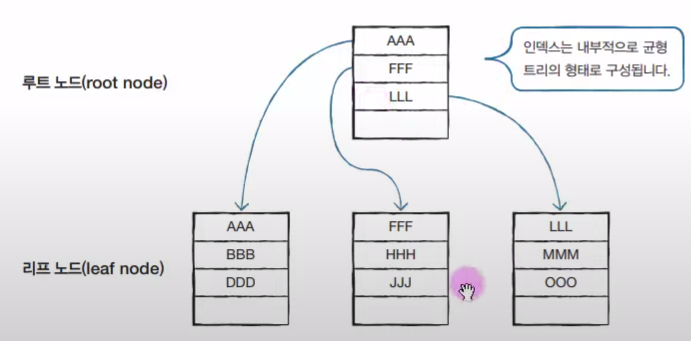

* **페이지**: 최소한의 저장 단위, 16kbyte 크기를 가진다.
* 예를 들어 데이터를 1건만 입력해도 1개 페이지가 필요함
* 만약 인덱스가 존재하지 않는다면 모두 리프 페이지만 있으므로 처음부터 검색하는 방법밖에 없다.
* 데이터를 처음부터 끝까지 검색하는 것을 전체 테이블 검색(Full Table Scan)이라고 부른다.

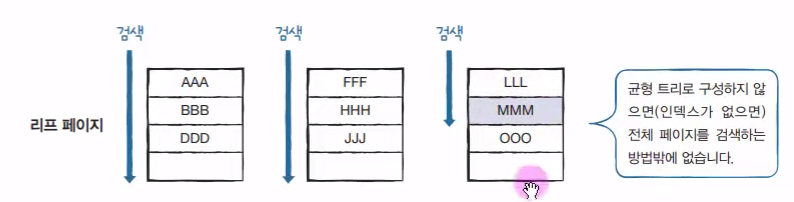

* 균형 트리에서 검색하게 되면 균형 트리는 무조건 루트 페이지부터 검색한다.
* 모든 데이터는 정렬되어 있고 MMM은 AAA, FFF, LLL 3개를 읽은 다음에 나오므로 세 번째 리프 페이지로 직접 이동하면 된다.
* 세 번째 리프 페이지에서 LLL, MMM 2개를 읽어 MMM을 찾았다.
* 루트 페이지에서 AAA, FFF, LLL 3개와 리프 페이지에서 LLL, MMM 2개, 합쳐서 5건의 데이터를 검색해서 원하는 결과를 찾았으며 페이지 2개를 읽었다.

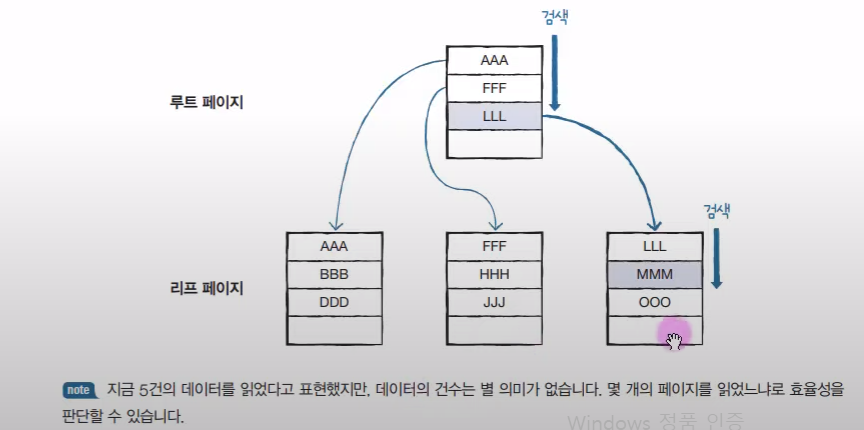

### 균형 트리의 페이지 분할

* 인덱스는 균형 트리로 구성되어 있고, 인덱스를 만들면 SELECT의 속도를 향상시킬 수 있으나 데이터 변경 작업(INSERT, UPDATE, DELETE) 시 성능이 나빠진다.
* 특히 INSERT 작업이 일어날 때 더 느리게 입력될 수 있는데 그 이유는 페이지 분할이라는 작업이 발생하기 때문이다.
* 페이지 분할: 새로운 페이지를 준비해서 데이터를 나누는 작업, 페이지 분할이 일어나면 MySQL이 느려지고, 너무 자주 일어나면 성능에 큰 영향을 준다.

* 앞에서 사용한 그림에 III데이터가 새로 INSERT되었다고 가정해보자. 균형 트리는 다음과 같이 변경될 것이다.

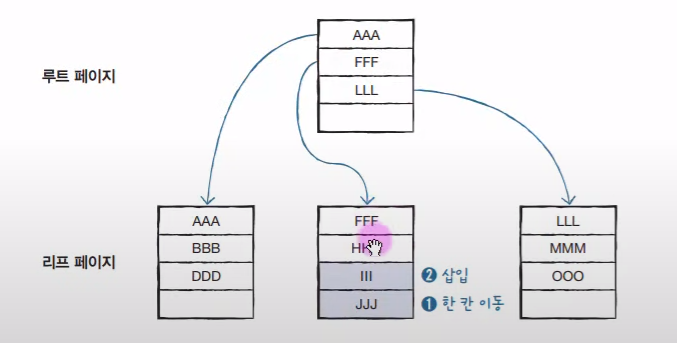

* 두 번째 리프 페이지에는 빈 공간이 있어서 JJJ가 아래로 한 칸 이동되고 III가 그 자리에 삽입되었다.
* 정렬되어야 하기 때문에 JJJ가 한 칸 이동했을 뿐 큰 변화는 일어나지 않았다. 즉 III를 입력하는 작업은 순식간에 처리된다.

* 만약 GGG를 입력하려고 할 경우, 두 번째 리프페이지에는 더 이상 빈 공간이 없다. 이럴때 페이지 분할 작업이 일어난다.
* 다음과 같이 새 페이지를 확보한 후 페이지 분할 작업이 1회 일어났고, 루트 페이지에도 새로 등록된 페이지의 제일 뒤에 있는 데이터 III가 등록되었다.

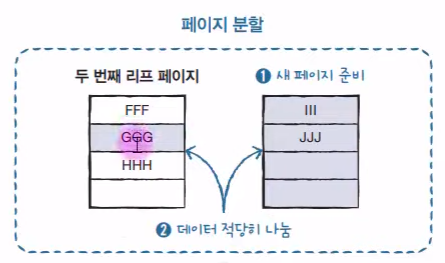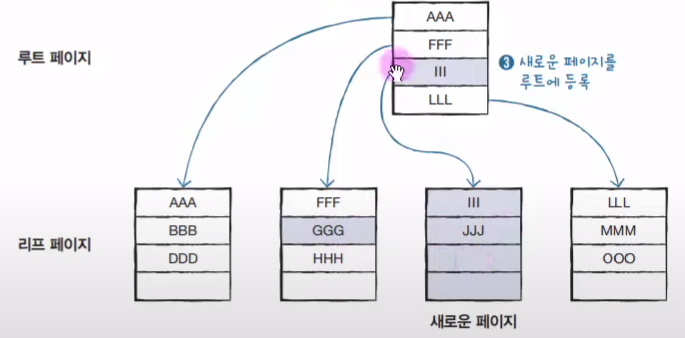

* 이번에는 PPP와 QQQ 2개를 연속해서 입력해보자.
* 다음 그림에서 PPP를 입력하면 네 번째 리프 페이지에 빈칸이 있으므로 제일 마지막에 추가된다.
* QQQ를 입력하려고 보니 네 번째 리프 페이지에는 빈 칸이 없으므로 페이지 분할이 일어난다.
* 페이지 분할 후에 추가된 다섯 번째 리프 페이지를 루트 페이지에 등록하려고 하니, 루트 페이지도 이미 꽉차서 더 이상 등록할 곳이 없다.
* 루트 페이지도 다시 페이지 분할을 하게 되고, 원래 루트 페이지가 있던 곳은 2개의 페이지가 되어 중간 페이지가 된다.
* 새 페이지를 준비해서 중간 노드를 가리키는 새로운 루트 페이지로 구성된다.
* 이러한 과정을 통해 인덱스를 구성 시에 데이터변경 작업이 느려지는지 알 수 있다.

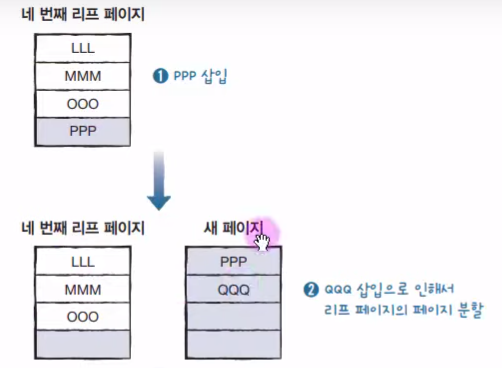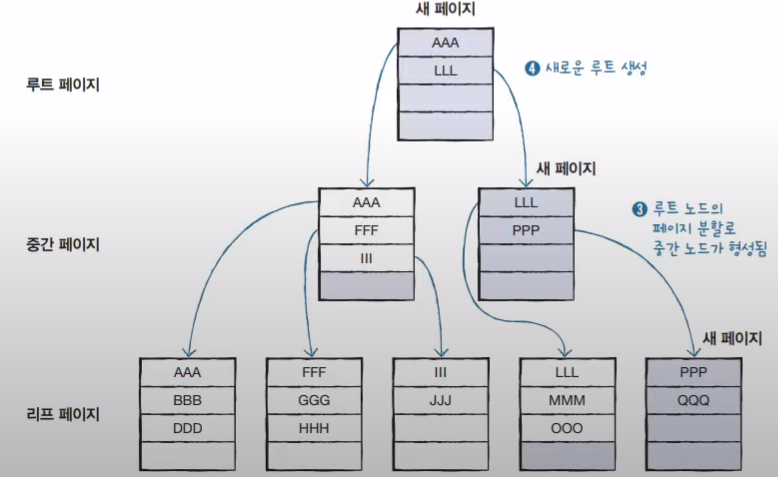

## 인덱스의 구조

### 클러스터형 인덱스 구성하기

In [ ]:
# 클러스터형 인덱스 구성을 위한 테이블 생성 및 삽입
USE market_db;
# 클러스터형 인덱스를 테스트하기 위한 테이블
CREATE TABLE cluster
(mem_id CHAR(8),
mem_name VARCHAR(10)
);
INSERT INTO cluster VALUES('TWC', '트와이스');
INSERT INTO cluster VALUES('BLK', '블랙핑크');
INSERT INTO cluster VALUES('WMN', '여자친구');
INSERT INTO cluster VALUES('OMY', '오마이걸');
INSERT INTO cluster VALUES('GRL', '소녀시대');
INSERT INTO cluster VALUES('ITZ', '잇지');
INSERT INTO cluster VALUES('RED', '레드벨벳');
INSERT INTO cluster VALUES('APN', '에이핑크');
INSERT INTO cluster VALUES('SPC', '우주소녀');
INSERT INTO cluster VALUES('MMU', '마마무');

* 정렬된 순서를 확인해보면 입력한 순서와 동일한 순서로 보일 것이다.

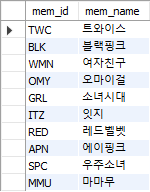

In [ ]:
# mem_id에 클러스터형 인덱스 구성
# mem_id를 Primary Key로 지정하면 클러스터형 인덱스로 구성
ALTER TABLE cluster
ADD CONSTRAINT
PRIMARY KEY(mem_id);

In [ ]:
# 데이터 확인
SELECT * FROM cluster;

* 결과를 보면 mem_id를 기준으로 오름차순 정렬되었다.
* mem_id열을 Primary Key로 지정했으나 클러스터형 인덱스가 생성되어 그렇다.

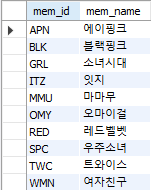

* 실제 데이터는 다음과 같이 데이터 페이지가 정렬되고 균형 트리 형태의 인덱스가 형성된다.
* 먼저 클러스터형 인덱스를 구성하기 위해 행 데이터를 지정한 열로 정렬한다.
* 각 페이지의 인덱스로 지정된 열의 첫 번째 값을 가지고 루트 페이지를 만든다.

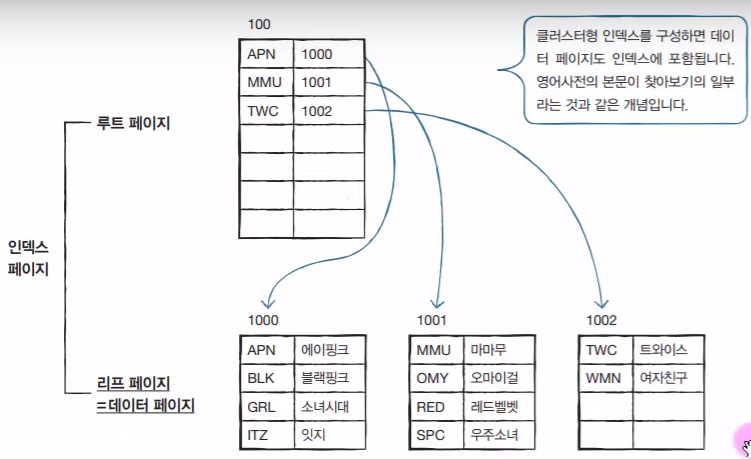

### 보조 인덱스 구성하기

In [ ]:
# 보조 인덱스 구성
USE market_db;
CREATE TABLE second
(mem_id CHAR(8),
mem_name VARCHAR(10)
);
INSERT INTO second VALUES('TWC', '트와이스');
INSERT INTO second VALUES('BLK', '블랙핑크');
INSERT INTO second VALUES('WMN', '여자친구');
INSERT INTO second VALUES('OMY', '오마이걸');
INSERT INTO second VALUES('GRL', '소녀시대');
INSERT INTO second VALUES('ITZ', '잇지');
INSERT INTO second VALUES('RED', '레드벨벳');
INSERT INTO second VALUES('APN', '에이핑크');
INSERT INTO second VALUES('SPC', '우주소녀');
INSERT INTO second VALUES('MMU', '마마무');

In [ ]:
# mem_id 열에 UNIQUE를 지정하고 데이터 확인
ALTER TABLE second
ADD CONSTRAINT
UNIQUE(mem_id);
SELECT * FROM second;

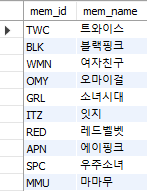

* 보조 인덱스가 생성되었는데도 입력한 것과 순서가 동일함
* 보조 인덱스는 데이터 페이지를 건드리지 않았다. 대신 보조 인덱스가 별도의 공간에 만들어진다.
* 인덱스 페이지의 리프 페이지에 인덱스로 구성한 열(예시에서는 mem_id)을 정렬한다.(일반 책의 찾아보기와 유사한 정렬방식)
* 실제 데이터가 있는 위치 준비, 데이터의 위치는 페이지 번호+#위치로 기록되어 있다.
* 

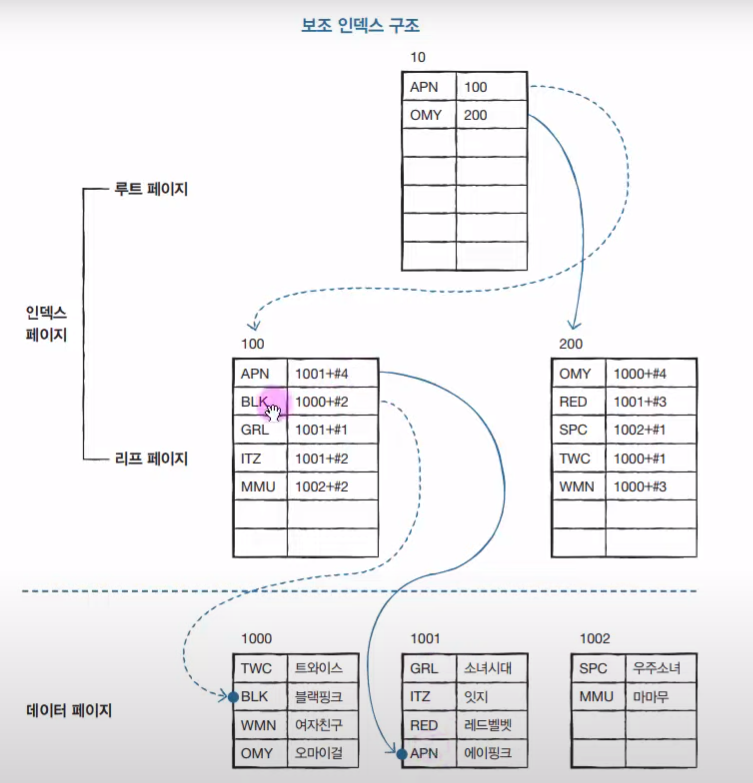

### 인덱스에서 데이터 검색하기

* 먼저 클러스터형 인덱스에서 검색을 해본다. 만약 SPC인 회원의 이름을 검색한다면 다음의 과정을 거치게 된다.
* 일단 루트 페이지(100번)을 읽어야 한다. SPC는 알파벳 순서로 따지면 MMU와 TWC 사이에 있으므로 루트 페이지의 MMU가 가리키는 리프 페이지의 1001번으로  이동한다.
* 리프 페이지(1001번)를 읽으니 네 번째에 찾고자 하는 SPC가 있고 이름이 '우주소녀'인 것을 알아냈다.
* 총 2개 페이지를 읽어서 SPC이름을 알아냈다.

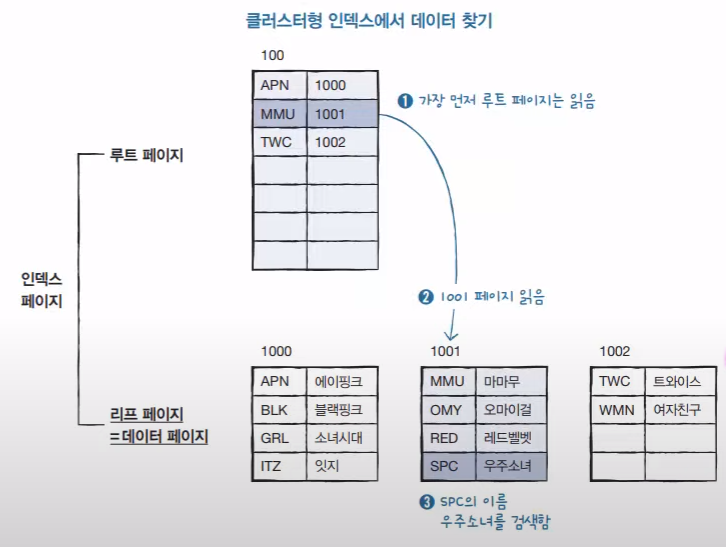

* 이번에는 보조 인덱스에서 SPC 회원의 이름을 검색해본다.
* SPC를 검색할 때 인덱스 페이지의 루트 페이지(10번), 리프 페이지(200번)를 읽는다.
* 데이터 페이지(1002번)를 읽어서 SPC의 이름이 '우주소녀'인 것을 알아낸디.
* 총 3개 페이지를 읽어서 SPC의 이름을 알아냈다.

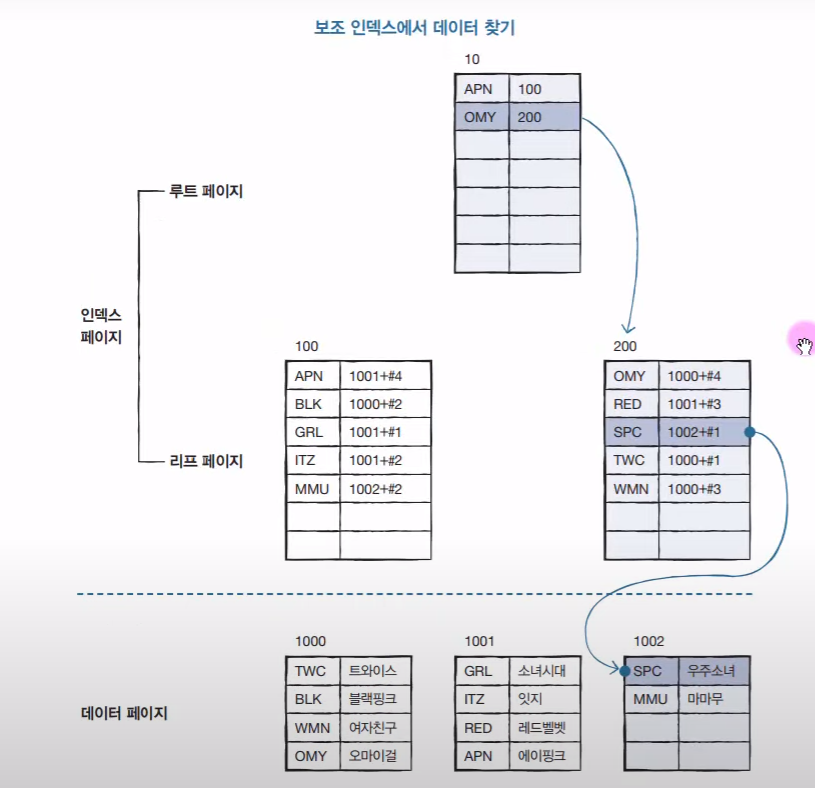

* 인덱스 검색을 통해 클러스터형 인덱스는 2페이지만 읽어서 원하는 결과를 검색했고, 보조 인덱스는 3페이지를 읽어서 원하는 결과를 검색했다.
* 두 인덱스 모두 검색이 빠르기는 하지만 클러스터형 인덱스가 조금 더 빠르다.